## part 1 : Qauntization
1. We would like to estimate the probability density function (pdf) of the gray levels in the image using the image histogram.

 If the histogram seems too uniform, please pick another image with a non-uniform distribution.

In [66]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

(512, 512)


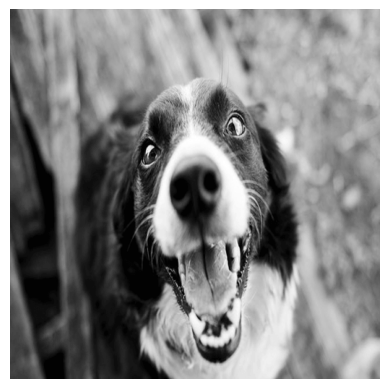

In [67]:
url = 'https://onlinetools.com/images/examples-onlineimagetools/black-dog-gray-srgb.png'

response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('L')
image_gray = image.resize((512, 512))

# check if the image is grey-scale imgae
# if the output is: (height, width) — The image is grayscale.
image_array = np.array(image_gray)
print(image_array.shape)

plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

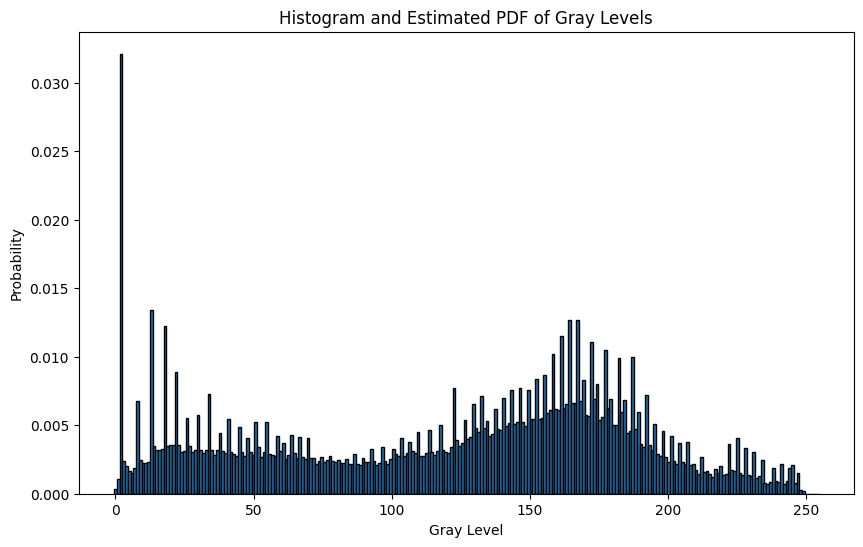

In [68]:
histogram, bin_edges = np.histogram(image_array, bins=256, range=(0, 255))
# Normalize the histogram to get the PDF
pdf = histogram / np.sum(histogram)

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], pdf, width=1, edgecolor='black')
plt.title('Histogram and Estimated PDF of Gray Levels')
plt.xlabel('Gray Level')
plt.ylabel('Probability')
plt.show()


2. Apply uniform quantization on the image using b bits per pixel:

 a. Show the MSE as a function of the bit-budget b for b = 1,...,8.

 b. Plot the decision and representation levels for representative b values.

In [69]:
def uniform_quantizer(image_array, b):
    """
    Applies uniform quantization to an image.

    Parameters:
    - image_array: NumPy array of the image.
    - b: Number of bits per pixel.

    Returns:
    - quantized_image: Quantized image as a NumPy array.
    - mse: Mean squared error between the original and quantized image.
    - decision_levels: Array of decision levels.
    - representation_levels: Array of representation levels.
    """
    L = 2 ** b # Number of quantization levels
    decision_levels = np.linspace(0, 255, L + 1) # decision levels (uniformly spaced)
    representation_levels = (decision_levels[:-1] + decision_levels[1:]) / 2  # representation levels (midpoints)

    # Initialize quantized image
    quantized_image = np.zeros_like(image_array, dtype=np.float32)

    # Quantize the image
    for i in range(L):
        lower = decision_levels[i]
        upper = decision_levels[i + 1]
        mask = (image_array >= lower) & (image_array < upper) # for all pixels that hold true
        quantized_image[mask] = representation_levels[i]

    # Handle the edge case for the maximum gray level
    quantized_image[image_array == 255] = representation_levels[-1]

    # Compute MSE
    mse = np.mean((image_array - quantized_image) ** 2)

    return quantized_image, mse, decision_levels, representation_levels


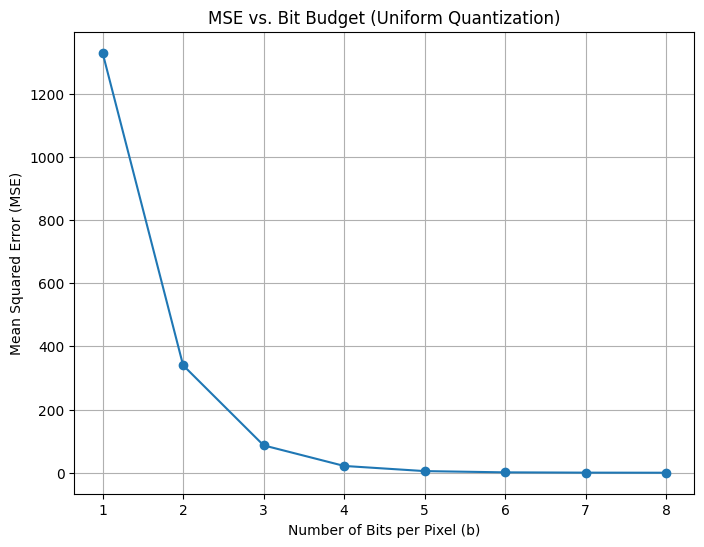

In [70]:
mse_values_uniform = []
# Bit budgets from 1 to 8
b_values = range(1, 9)
for b in b_values:
    quantized_image, mse, decision_levels, representation_levels = uniform_quantizer(image_array, b)
    mse_values_uniform.append(mse)

# Plot MSE vs. b
plt.figure(figsize=(8, 6))
plt.plot(b_values, mse_values_uniform, marker='o')
plt.title('MSE vs. Bit Budget (Uniform Quantization)')
plt.xlabel('Number of Bits per Pixel (b)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


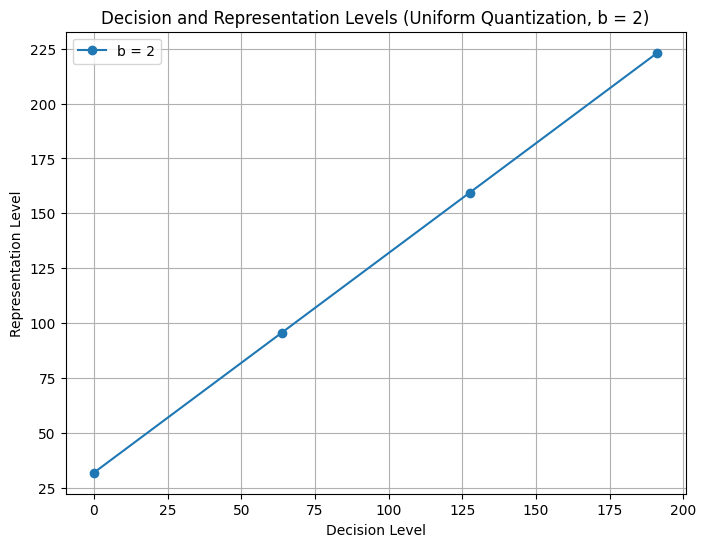

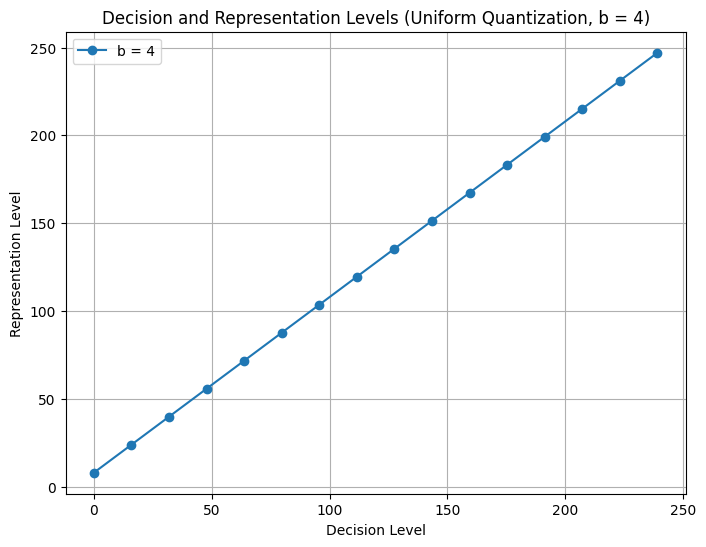

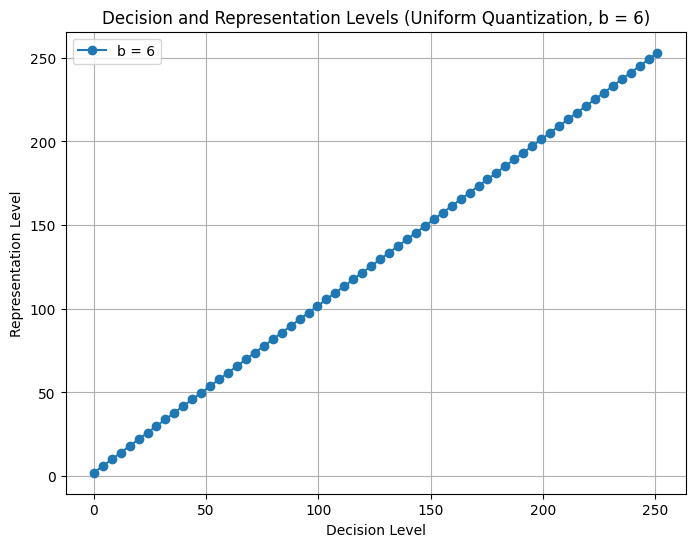

In [71]:
representative_b_values = [2, 4, 6]

for b in representative_b_values:
    _, _, decision_levels, representation_levels = uniform_quantizer(image_array, b)

    # Plot decision and representation levels
    plt.figure(figsize=(8, 6))
    plt.plot(decision_levels[:-1], representation_levels, 'o-', label=f'b = {b}')
    plt.title(f'Decision and Representation Levels (Uniform Quantization, b = {b})')
    plt.xlabel('Decision Level')
    plt.ylabel('Representation Level')
    plt.legend()
    plt.grid(True)
    plt.show()


3. Implement the Max-Lloyd algorithm. This should be a function taking as input
 a histogram pdf, a vector of initial decision levels, and a small value ε > 0 for convergence tolerance. The function should return the converged decision levels and  the converged representation levels. In order to handle numerical approximations,  we use ε as a stopping condition: when the MSE improves by less than ε we stop the algorithm.

In [72]:
def max_lloyd_quantizer(pdf, initial_decision_levels, epsilon=1e-5):
    """
    Implements the Max-Lloyd algorithm for optimal scalar quantization.

    Parameters:
    - pdf: Estimated PDF of the gray levels (array of length 256).
    - initial_decision_levels: Initial decision levels (array).
    - epsilon: Convergence tolerance.

    Returns:
    - decision_levels: Converged decision levels.
    - representation_levels: Converged representation levels.
    """
    decision_levels = initial_decision_levels.copy()
    L = len(decision_levels) - 1  # Number of quantization intervals
    representation_levels = np.zeros(L)

    # variables for convergence check
    previous_mse = np.inf
    delta_mse = np.inf

    # Gray levels array
    gray_levels = np.arange(256)

    # Max-Lloyd iteration
    while delta_mse > epsilon:
        # Update representation levels
        for i in range(L):
            # Get indices of gray levels within the current interval
            indices = np.where((gray_levels >= decision_levels[i]) & (gray_levels < decision_levels[i + 1]))[0]
            if len(indices) == 0:
                representation_levels[i] = (decision_levels[i] + decision_levels[i + 1]) / 2
            else:
                p = pdf[indices]
                x = gray_levels[indices]
                numerator = np.sum(x * p)
                denominator = np.sum(p)
                if denominator == 0:
                    representation_levels[i] = (decision_levels[i] + decision_levels[i + 1]) / 2
                else:
                    representation_levels[i] = numerator / denominator

        # Update decision levels
        new_decision_levels = np.zeros(L + 1)
        new_decision_levels[0] = 0
        new_decision_levels[-1] = 255
        for i in range(1, L):
            new_decision_levels[i] = (representation_levels[i - 1] + representation_levels[i]) / 2

        # Compute current MSE
        mse = 0
        for i in range(L):
            indices = np.where((gray_levels >= decision_levels[i]) & (gray_levels < decision_levels[i + 1]))[0]
            if len(indices) == 0:
                continue
            p = pdf[indices]
            x = gray_levels[indices]
            mse += np.sum(((x - representation_levels[i]) ** 2) * p)

        # Check convergence
        delta_mse = np.abs(previous_mse - mse)
        previous_mse = mse

        # Update decision levels
        decision_levels = new_decision_levels.copy()

    return decision_levels, representation_levels

 4. Apply the Max-Lloyd quantizer starting with uniform quantization

 a. Show the MSE as a function of the bit-budget b for b = 1,...,8.

 b. Plot the decision and representation levels for representative b values.

 c. Compare the results to those of the uniform quantizer. Explain the differences.

In [73]:
mse_values_max_lloyd = []

for b in b_values:
    # Get initial decision levels from uniform quantization
    L = 2 ** b
    initial_decision_levels = np.linspace(0, 255, L + 1)

    # Apply Max-Lloyd algorithm
    decision_levels, representation_levels = max_lloyd_quantizer(pdf, initial_decision_levels)

    # Apply
    # Quantize the image
    quantized_image = np.zeros_like(image_array, dtype=np.float32)

    for i in range(L):
        lower = decision_levels[i]
        upper = decision_levels[i + 1]
        mask = (image_array >= lower) & (image_array < upper)
        quantized_image[mask] = representation_levels[i]

    # Handle the edge case for the maximum gray level
    quantized_image[image_array == 255] = representation_levels[-1]

    # Compute MSE
    mse = np.mean((image_array - quantized_image) ** 2)
    mse_values_max_lloyd.append(mse)


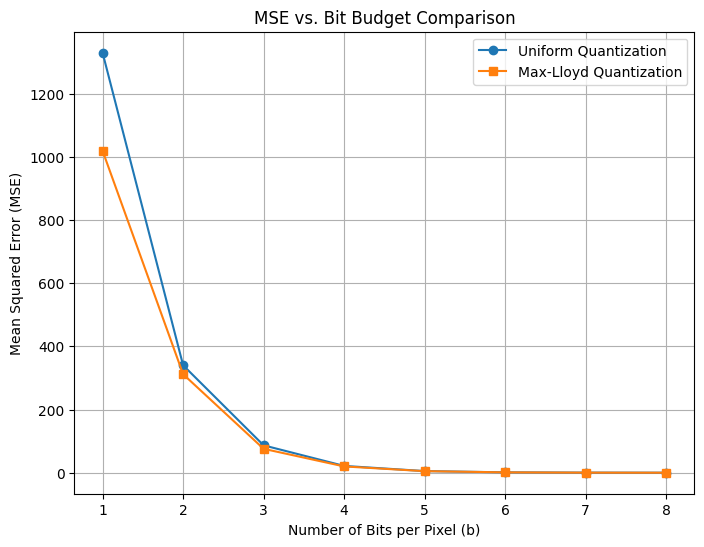

In [74]:
# Plot MSE vs. b for both quantizers
plt.figure(figsize=(8, 6))
plt.plot(b_values, mse_values_uniform, marker='o', label='Uniform Quantization')
plt.plot(b_values, mse_values_max_lloyd, marker='s', label='Max-Lloyd Quantization')
plt.title('MSE vs. Bit Budget Comparison')
plt.xlabel('Number of Bits per Pixel (b)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


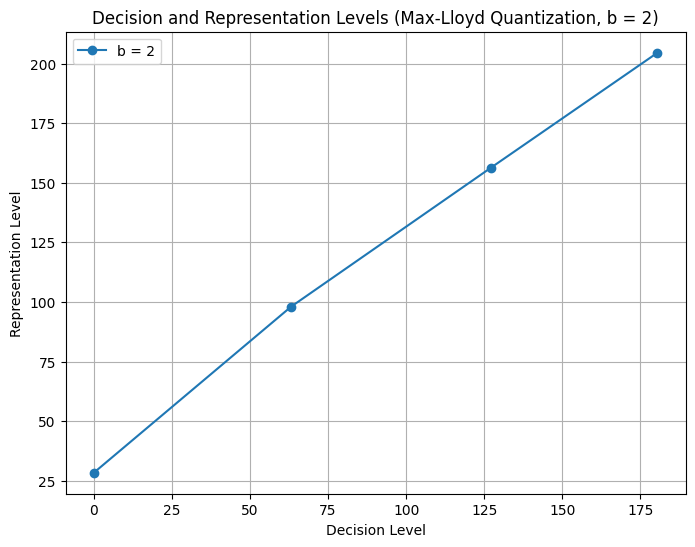

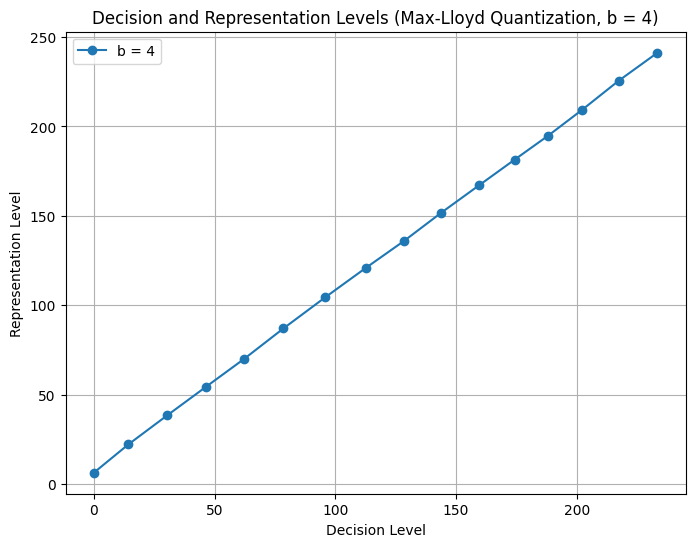

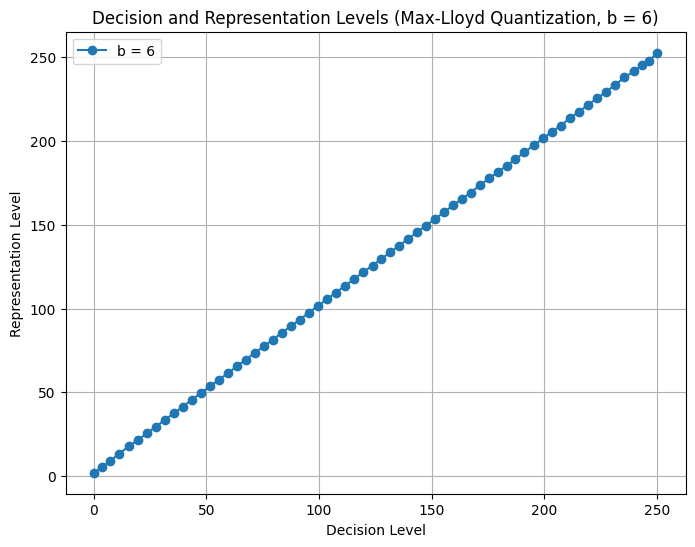

In [75]:
for b in representative_b_values:
    # Get initial decision levels
    L = 2 ** b
    initial_decision_levels = np.linspace(0, 255, L + 1)

    # Apply Max-Lloyd algorithm
    decision_levels, representation_levels = max_lloyd_quantizer(pdf, initial_decision_levels)

    # Plot decision and representation levels
    plt.figure(figsize=(8, 6))
    plt.plot(decision_levels[:-1], representation_levels, 'o-', label=f'b = {b}')
    plt.title(f'Decision and Representation Levels (Max-Lloyd Quantization, b = {b})')
    plt.xlabel('Decision Level')
    plt.ylabel('Representation Level')
    plt.legend()
    plt.grid(True)
    plt.show()


comparing Quantization Methods
MSE as a Function of bits per pixel (b):

Both methods show decreasing MSE with increasing b.
Max-Lloyd quantization typically achieves lower MSE for the same b.